# Generating an Image Captions Dataset

Image captions are natural language descriptions of an image. Models like CLIP and DALL-E were trained on millions of image-caption pairs to enable them to take text as input for generating an image. This is called *text-to-image generation*, where a model learns to understand the relationship between text and visual elements. The process through which these models learn this semantic text-image relationship is called *text conditioning*.

### Generating Image Captions
If the data you are working with does not have text captions, you can generate them yourself using any image-to-text model. 

In this notebook, we'll explain step-by-step how to use the Google's PaliGemma model to generate image captions for a dataset of animal faces. The same technique can be applied on any dataset of images.

## 1. Get the data

First, we must download our chosen dataset.

In [1]:
# To use the files in the parent directory run this cell
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

len(train_dataset): 14630
len(val_dataset): 1500


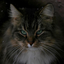

In [4]:
# Load raw image data
from src.datasets.hugging_face_dataset import HuggingFaceDataset

dataset_name = "zzsi/afhq64_16k"
train_dataset = HuggingFaceDataset(dataset_name, split="train")
val_dataset = HuggingFaceDataset(dataset_name, split="val")
print(f"len(train_dataset): {len(train_dataset)}")
print(f"len(val_dataset): {len(val_dataset)}")
train_dataset[0][0]

## 2. Get the model

Now, we can use HuggingFace to easily run inference on the PaliGemma model. 

In [5]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch

model_id = "google/paligemma-3b-mix-224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval().to(device)
processor = AutoProcessor.from_pretrained(model_id)


2025-01-19 09:51:26.517652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 09:51:26.593677: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 09:51:26.967691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2025-01

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## 3. Generating captions
Let's try to generate a caption for the first image. PaliGemma requires an image and a text prompt. To output caption-like text, we can use the prompt `"<image> caption en"` where the `<image>` will automatically get replaced by the input image.

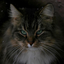

A close-up of a fluffy cat with green eyes. The cat has a long white beard, a white chin, and long whiskers. Its eyes are green, and its nose is pink. The cat is looking at the camera with a serious expression. The background is dark.


In [6]:
# Display the image
image = train_dataset[0][0]
display(image)

def generate_caption(image):
    # Setup the model inputs
    prompt = "<image> caption en"
    model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
    input_len = model_inputs["input_ids"].shape[-1]

    # Generate the caption
    with torch.inference_mode():
        generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)

    return decoded

caption = generate_caption(image)
print(caption)

Awesome! Let's look at a few more just for fun.

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


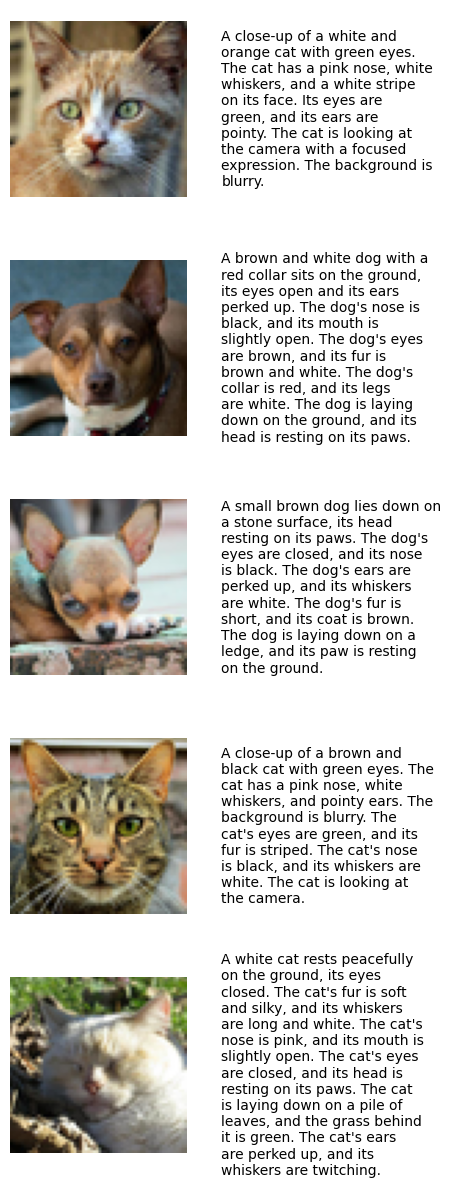

In [7]:
import matplotlib.pyplot as plt
import random
import textwrap
from tqdm import tqdm

# Select a random 5 images from the dataset
dataset = random.sample(list(train_dataset), 5)

# Generate captions for each image
def generate_captions_for_dataset(dataset):
    captions = []
    for data in tqdm(dataset):
        image = data[0]
        captions.append(generate_caption(image))
    return captions

captions = generate_captions_for_dataset(dataset)

# Plot images with captions
fig, axs = plt.subplots(len(dataset), 2, figsize=(5, 15))

for i in range(len(dataset)):
    axs[i, 0].imshow(dataset[i][0])
    axs[i, 0].axis('off')
    caption = textwrap.fill(captions[i], 30)
    axs[i, 1].text(0.0, 0.5, caption, verticalalignment='center', wrap=True)
    axs[i, 1].axis('off')


## 4. Generating captions for the whole dataset

The rest of this notebook will show how you can generate captions for the full dataset and upload to Hugging Face for easy access.

Generating captions for the entire train and val sets could take a long time depending on your hardware, and is not necessary for this course, so if you want you can use a subset of the dataset instead.

In [8]:
train_dataset = list(train_dataset)[:10] # Comment this to generate captions for the entire dataset
train_captions = generate_captions_for_dataset(train_dataset)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


In [ ]:
val_dataset = list(val_dataset)[:2] # Comment this to generate captions for the entire dataset
val_captions = generate_captions_for_dataset(val_dataset)

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


# 

## 5a. (Optional) Write to a json file

If you don't want to upload to HuggingFace, you can simply write the captions to json.

In [11]:
import json

def write_captions_json(captions, filename):
    with open(filename, "w") as f:
        json.dump(captions, f)

train_captions_filename = "train_captions.json"
val_captions_filename = "val_captions.json"
write_captions_json(train_captions, train_captions_filename)
write_captions_json(val_captions, val_captions_filename)

## 5b. (Optional) Upload to Hugging Face

Uploading to Hugging Face will require a HF account, but will allow you to save your dataset for free on the internet. Also, this will allow other people to try out your dataset!

In [ ]:
# take a torch dataset and push to huggingface
# https://huggingface.co/docs/huggingface_hub/v0.25.0/en/tutorials/push_to_hub
from datasets import Dataset, DatasetDict

user_name = "<YOUR-USERNAME-HERE>"
resolution = 64

# Convert torch dataset to huggingface dataset
def gen_ds(dataset, labels):
    for i, (img, label) in enumerate(dataset):
        yield {"image": img, "label": label, f"caption": labels[i]}

train_ds_hf = Dataset.from_generator(gen_ds, gen_kwargs={"dataset": train_dataset, "labels": train_captions})
val_ds_hf = Dataset.from_generator(gen_ds, gen_kwargs={"dataset": val_dataset, "labels": val_captions})

dataset_dict = DatasetDict({"train": train_ds_hf, "val": val_ds_hf})
dataset_dict.push_to_hub(f"{user_name}/afhq_paligemma_captions_test.json", create_pr=False)